In [1]:
import os 
import sys
import shutil

# Get the current working directory and navigate to project root
# Assuming we're running from the notebooks folder
current_dir = os.getcwd()

# If we're in the notebooks folder, go up one level to project root
if current_dir.endswith('notebooks'):
    project_root = os.path.dirname(current_dir)
else:
    # If we're already in project root or somewhere else, assume current dir is project root
    project_root = current_dir

# Clean Python cache files
def clean_python_cache(root_dir):
    """Remove all Python cache files and directories"""
    cache_dirs_removed = 0
    cache_files_removed = 0
    
    for root, dirs, files in os.walk(root_dir):
        # Remove __pycache__ directories
        if '__pycache__' in dirs:
            pycache_path = os.path.join(root, '__pycache__')
            try:
                shutil.rmtree(pycache_path)
                cache_dirs_removed += 1
                print(f"Removed: {pycache_path}")
            except Exception as e:
                print(f"Failed to remove {pycache_path}: {e}")
        
        # Remove .pyc files
        for file in files:
            if file.endswith('.pyc'):
                pyc_path = os.path.join(root, file)
                try:
                    os.remove(pyc_path)
                    cache_files_removed += 1
                    print(f"Removed: {pyc_path}")
                except Exception as e:
                    print(f"Failed to remove {pyc_path}: {e}")
    
    print(f"\nCache cleanup complete:")
    print(f"- Removed {cache_dirs_removed} __pycache__ directories")
    print(f"- Removed {cache_files_removed} .pyc files")

# Clean cache files
print("Cleaning Python cache files...")
clean_python_cache(project_root)

# Add project root to path for absolute imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Add src and models directories as well
paths_to_add = ['src', 'models']
for path_name in paths_to_add:
    full_path = os.path.join(project_root, path_name)
    if os.path.exists(full_path) and full_path not in sys.path:
        sys.path.insert(0, full_path)

Cleaning Python cache files...
Removed: /teamspace/studios/this_studio/informer-validation/src/ml/__pycache__
Removed: /teamspace/studios/this_studio/informer-validation/models/__pycache__
Removed: /teamspace/studios/this_studio/informer-validation/models/informer/__pycache__

Cache cleanup complete:
- Removed 3 __pycache__ directories
- Removed 0 .pyc files


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from pytorch_forecasting.data.timeseries import TimeSeriesDataSet
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score

import hydra
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

# Import from ml package (not src.ml) since src is now in the path
from src.ml.data import build_time_series_dataset
from src.ml.loss import get_loss
from src.ml.model import get_model

# Clear any existing Hydra instance
GlobalHydra.instance().clear()

# Initialize Hydra with the config directory
# Assuming your config files are in the project root under 'config/'
with initialize(config_path="../config", version_base=None):
    conf = compose(config_name="informer_original_r2.yaml")

# Get time series dataset
df = pd.read_csv(conf['data']['path'])
df['weekday'] = df['weekday'].astype(str)
df['hour'] = df['hour'].astype(str)

train_df, val_df = train_test_split(df, test_size=0.2, shuffle=False)
val_df, test_df = train_test_split(val_df, test_size=0.5, shuffle=False)
    
train_dataset: TimeSeriesDataSet = build_time_series_dataset(conf, train_df)
val_dataset: TimeSeriesDataSet = TimeSeriesDataSet.from_dataset(train_dataset, val_df, predict=False)
test_dataset: TimeSeriesDataSet = TimeSeriesDataSet.from_dataset(train_dataset, test_df, predict=False)

Target variable: returns
Train target stats:
  Mean: 0.000008
  Std: 0.001465
  Skewness: -0.653585
  Kurtosis: 78.368996

Applying QuantileTransformer to target variable...

Transformed train target stats:
  Mean: -0.002425
  Std: 1.005143
  Skewness: 0.011735
  Kurtosis: -0.085961


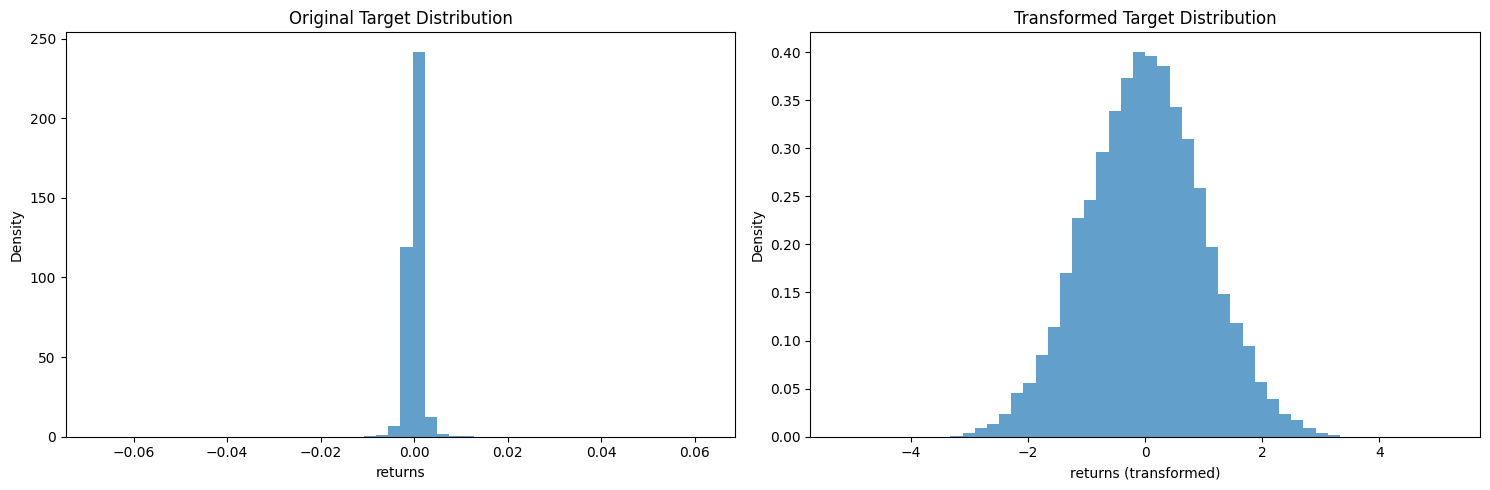


QuantileTransformer fitted and applied successfully!
Transformer saved as 'qt' variable for inverse transformation during evaluation.


In [3]:
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt

# Analyze target distribution before transformation
target_col = conf['data']['target']
print(f"Target variable: {target_col}")
print(f"Train target stats:")
print(f"  Mean: {train_df[target_col].mean():.6f}")
print(f"  Std: {train_df[target_col].std():.6f}")
print(f"  Skewness: {train_df[target_col].skew():.6f}")
print(f"  Kurtosis: {train_df[target_col].kurtosis():.6f}")

# Apply QuantileTransformer to target variable
print("\nApplying QuantileTransformer to target variable...")
qt = QuantileTransformer(output_distribution='normal', random_state=42)

# Fit on train data only
train_target_transformed = qt.fit_transform(train_df[[target_col]])
train_df_transformed = train_df.copy()
train_df_transformed[target_col] = train_target_transformed.flatten()

# Transform validation and test data
val_target_transformed = qt.transform(val_df[[target_col]])
val_df_transformed = val_df.copy()
val_df_transformed[target_col] = val_target_transformed.flatten()

test_target_transformed = qt.transform(test_df[[target_col]])
test_df_transformed = test_df.copy()
test_df_transformed[target_col] = test_target_transformed.flatten()

print(f"\nTransformed train target stats:")
print(f"  Mean: {train_df_transformed[target_col].mean():.6f}")
print(f"  Std: {train_df_transformed[target_col].std():.6f}")
print(f"  Skewness: {train_df_transformed[target_col].skew():.6f}")
print(f"  Kurtosis: {train_df_transformed[target_col].kurtosis():.6f}")

# Plot before and after transformation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original distribution
ax1.hist(train_df[target_col], bins=50, alpha=0.7, density=True)
ax1.set_title('Original Target Distribution')
ax1.set_xlabel(target_col)
ax1.set_ylabel('Density')

# Transformed distribution
ax2.hist(train_df_transformed[target_col], bins=50, alpha=0.7, density=True)
ax2.set_title('Transformed Target Distribution')
ax2.set_xlabel(f'{target_col} (transformed)')
ax2.set_ylabel('Density')

plt.tight_layout()
plt.show()

# Store the transformer for later inverse transformation
print("\nQuantileTransformer fitted and applied successfully!")
print(f"Transformer saved as 'qt' variable for inverse transformation during evaluation.")

In [4]:
# Create datasets with transformed target variable
print("Creating TimeSeriesDataSet with transformed target...")

# train_dataset: TimeSeriesDataSet = build_time_series_dataset(conf, train_df_transformed)
# val_dataset: TimeSeriesDataSet = TimeSeriesDataSet.from_dataset(train_dataset, val_df_transformed, predict=False)
# test_dataset: TimeSeriesDataSet = TimeSeriesDataSet.from_dataset(train_dataset, test_df_transformed, predict=False)
# test_dataset: TimeSeriesDataSet = build_time_series_dataset(conf, test_df_transformed)

train_dataset: TimeSeriesDataSet = build_time_series_dataset(conf, train_df)
val_dataset: TimeSeriesDataSet = TimeSeriesDataSet.from_dataset(train_dataset, val_df, predict=False)
test_dataset: TimeSeriesDataSet = TimeSeriesDataSet.from_dataset(train_dataset, test_df, predict=False)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")  
print(f"Test dataset: {len(test_dataset)} samples")
print("\nDatasets created successfully with transformed target!")

Creating TimeSeriesDataSet with transformed target...


Train dataset: 184519 samples
Val dataset: 23040 samples
Test dataset: 23040 samples

Datasets created successfully with transformed target!


In [5]:
from models.informer.model_pytorch_forecasting import InformerPTForecasting
# Get loss
loss = get_loss(conf)

# model = get_model(conf, train_dataset, loss)
model = InformerPTForecasting.load_from_checkpoint("/teamspace/studios/this_studio/informer-validation/logs/Informer_BTC_5min/version_0/checkpoints/epoch=1-step=720.ckpt")

# model to eval mode
model.eval()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


InformerPTForecasting(
  	"activation":                        gelu
  	"attention_type":                    prob
  	"categorical_groups":                {}
  	"d_fully_connected":                 256
  	"d_model":                           256
  	"dataset_parameters":                {'time_idx': 'time_index', 'target': 'returns', 'group_ids': ['group_id'], 'weight': None, 'max_encoder_length': 28, 'min_encoder_length': 28, 'min_prediction_idx': 0, 'min_prediction_length': 2, 'max_prediction_length': 2, 'static_categoricals': [], 'static_reals': [], 'time_varying_known_categoricals': ['weekday', 'hour'], 'time_varying_known_reals': ['fed_funds_rate', 'vix_value', 'fng_value', 'vol_1d', 'vol_7d'], 'time_varying_unknown_categoricals': [], 'time_varying_unknown_reals': ['high', 'low', 'open', 'close', 'volume', 'open_to_close', 'high_to_close', 'low_to_close', 'high_to_low_price', 'returns', 'log_returns', 'vol_1h', 'macd', 'macd_signal', 'rsi', 'low_bband_to_close', 'up_bband_to_close', '

Generating predictions for 10 batches only...
Batch 1 actuals shape: (64,)
Batch 1 predictions shape: (64, 1)
Processed batch 1/10
Batch 2 actuals shape: (64,)
Batch 2 predictions shape: (64, 1)
Processed batch 2/10
Batch 3 actuals shape: (64,)
Batch 3 predictions shape: (64, 1)
Processed batch 3/10
Batch 4 actuals shape: (64,)
Batch 4 predictions shape: (64, 1)
Processed batch 4/10
Batch 5 actuals shape: (64,)
Batch 5 predictions shape: (64, 1)
Processed batch 5/10
Batch 6 actuals shape: (64,)
Batch 6 predictions shape: (64, 1)
Processed batch 6/10
Batch 7 actuals shape: (64,)
Batch 7 predictions shape: (64, 1)
Processed batch 7/10
Batch 8 actuals shape: (64,)
Batch 8 predictions shape: (64, 1)
Processed batch 8/10
Batch 9 actuals shape: (64,)
Batch 9 predictions shape: (64, 1)
Processed batch 9/10
Batch 10 actuals shape: (64,)
Batch 10 predictions shape: (64, 1)
Processed batch 10/10
Predictions shape: (640,)
Actuals shape: (640,)

Model Performance Metrics:
  Metric     Value
0    M

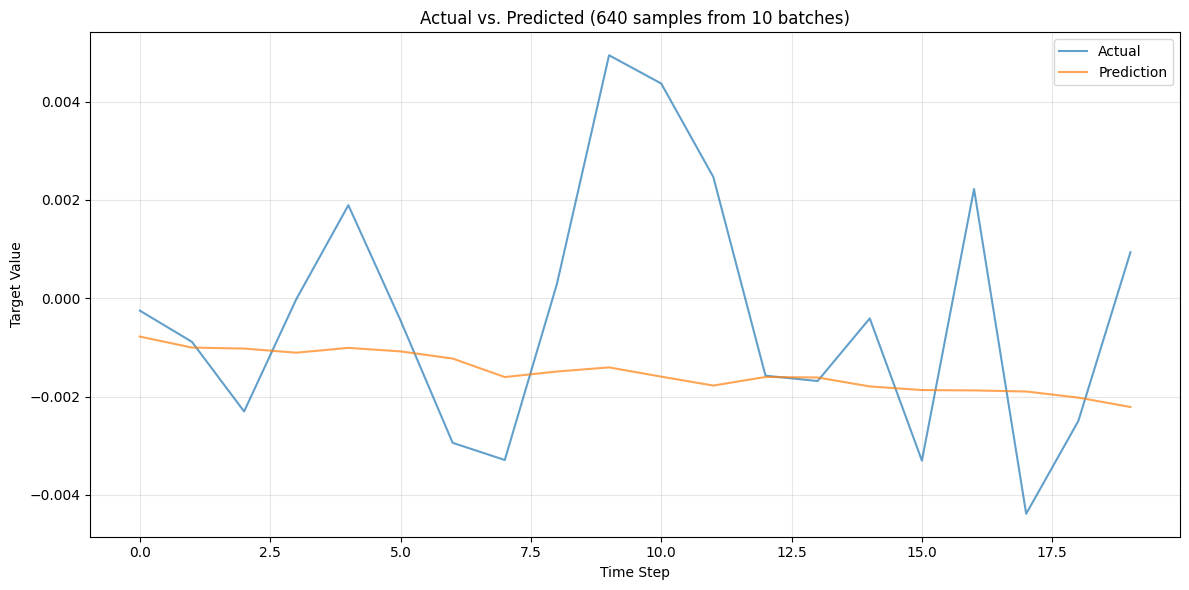

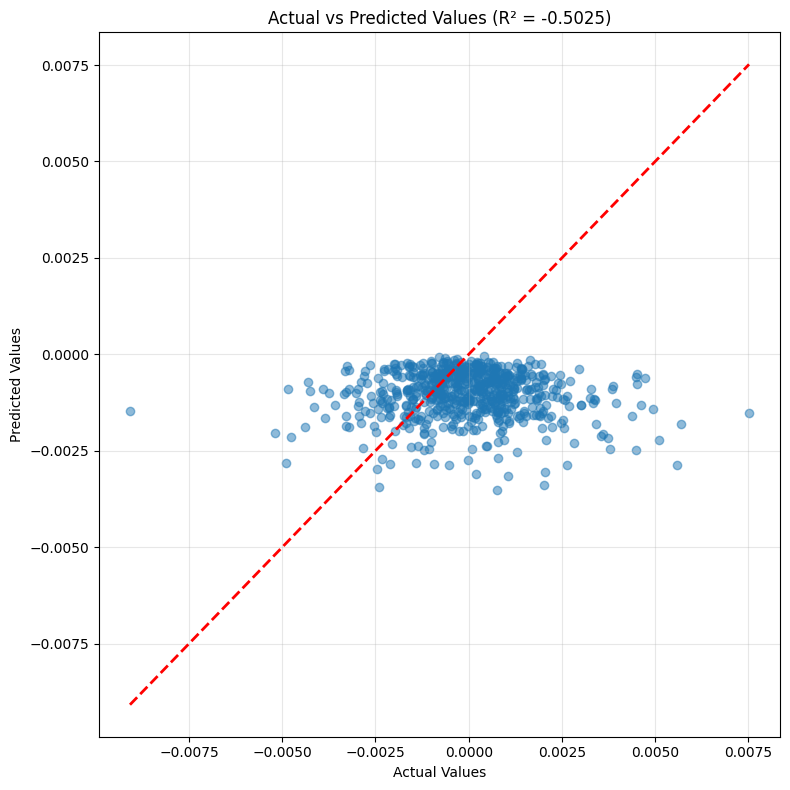

In [8]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Generating predictions for 10 batches only...")

# Get actual values from the test dataset (limit to 10 batches)
test_loader = test_dataset.to_dataloader(batch_size=64, shuffle=False)
all_actuals = []
all_preds = []

# Limit to 10 batches for faster inference
max_batches = 10
batch_count = 0

HORIZONT = 1

for batch_idx, (x, y) in enumerate(test_loader):
    if batch_count >= max_batches:
        break
    
    # Get actuals
    actuals = y[0].cpu().numpy()[:, 0]
    print(f"Batch {batch_idx + 1} actuals shape: {actuals.shape}")
    all_actuals.append(actuals.flatten())
    
    # Move batch to device and get predictions
    x = {k: v for k, v in x.items() if k != "encoder_target"}

    x_device = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in x.items()}
    
    with torch.no_grad():
        # Use the model's forward method directly
        batch_pred = model(x_device)
        
        preds = batch_pred['prediction'].cpu().numpy()
            
        # Extract the horizon we want
        if len(preds.shape) == 3:  # [batch, horizon, features]
            preds = preds[:, HORIZONT, :]
            # preds = preds
        elif len(preds.shape) == 2:  # [batch, features] 
            preds = preds
            
        print(f"Batch {batch_idx + 1} predictions shape: {preds.shape}")
        all_preds.append(preds.flatten())
    
    batch_count += 1
    print(f"Processed batch {batch_count}/{max_batches}")

all_actuals = np.concatenate(all_actuals)
all_preds = np.concatenate(all_preds)

# Ensure both arrays have the same length
min_length = min(len(all_preds), len(all_actuals))
all_preds = all_preds[:min_length]
all_actuals = all_actuals[:min_length]

print(f"Predictions shape: {all_preds.shape}")
print(f"Actuals shape: {all_actuals.shape}")

# Compute metrics
mae = mean_absolute_error(all_actuals, all_preds)
rmse = np.sqrt(mean_squared_error(all_actuals, all_preds))
r2 = r2_score(all_actuals, all_preds)

# Display metrics
metrics_df = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "R2"],
    "Value": [mae, rmse, r2]
})
print("\nModel Performance Metrics:")
print(metrics_df)

# Plot actual vs prediction (all points since we only have 10 batches)
plt.figure(figsize=(12, 6))
n_points = len(all_actuals)
plt.plot(all_actuals[300:320], label="Actual", alpha=0.7)
plt.plot(all_preds[300:320], label="Prediction", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Target Value")
plt.title(f"Actual vs. Predicted ({n_points} samples from 10 batches)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter plot for correlation
plt.figure(figsize=(8, 8))
plt.scatter(all_actuals, all_preds, alpha=0.5)
plt.plot([all_actuals.min(), all_actuals.max()], [all_actuals.min(), all_actuals.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted Values (R² = {r2:.4f})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

torch.Size([64, 28])
torch.Size([64, 2])
torch.Size([64, 2, 1])


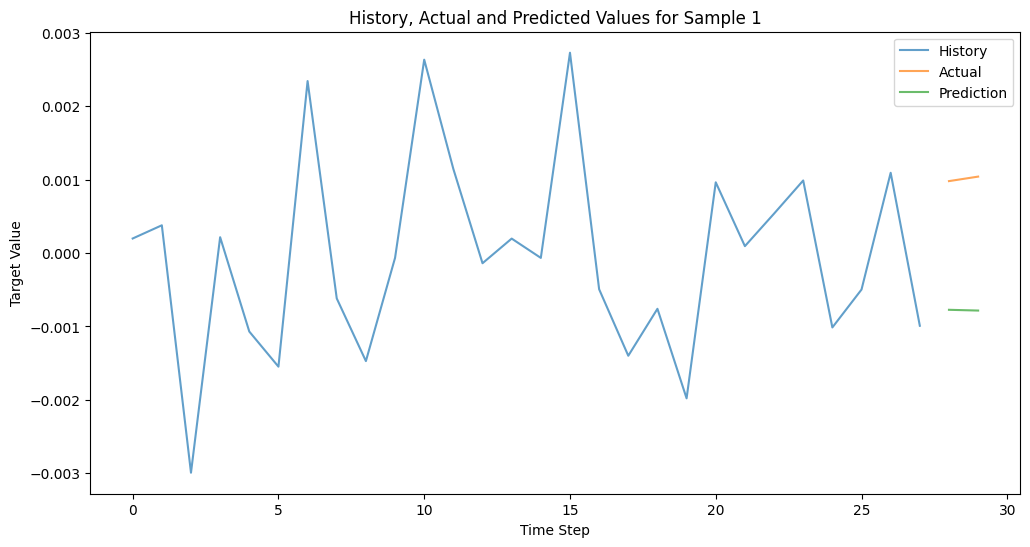

In [10]:
with torch.no_grad():
    X, y = next(iter(test_loader))

    # Move batch to device and get predictions
    # X = {k: v for k, v in X.items() if k != "encoder_target"}

    x_device = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in X.items()}
    predicitons = model(x_device)
    print(X['encoder_target'].shape)
    print(y[0].shape)
    print(predicitons['prediction'].shape)

    IDX = 1  # Index of the sample to visualize
    history = X['encoder_target'][IDX].cpu().numpy()
    autual = y[0][IDX].cpu().numpy()
    prediction = predicitons['prediction'][IDX].cpu().numpy().flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(history, label="History", alpha=0.7)
    plt.plot(np.arange(len(history), len(history) + len(autual)), autual, label="Actual", alpha=0.7)
    plt.plot(np.arange(len(history), len(history) + len(prediction)), prediction, label="Prediction", alpha=0.7)
    plt.xlabel("Time Step")
    plt.ylabel("Target Value")
    plt.title(f"History, Actual and Predicted Values for Sample {IDX}")
    plt.legend()